<a href="https://colab.research.google.com/github/soukhind2/vgg16obj/blob/tuning_calc/merge_set_tsne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preload

Mount the google drive and load necessary packages

In [1]:
from google.colab import drive

from pathlib import Path
import sys
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!rm -rf vgg16obj
!git clone -b tuning_calc https://github.com/soukhind2/vgg16obj
! pip install https://github.com/raghakot/keras-vis/archive/master.zip #keras vis

Cloning into 'vgg16obj'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 383 (delta 34), reused 29 (delta 9), pack-reused 307
Receiving objects: 100% (383/383), 8.05 MiB | 5.87 MiB/s, done.
Resolving deltas: 100% (211/211), done.
     - 52.7MB 912kB/s
  Created wheel for keras-vis: filename=keras_vis-0.5.0-py2.py3-none-any.whl size=30857 sha256=e0e98960a115eee7cb408cea62788854b1d5fabcd682fefe9b14fc2c8c283a5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-n6zot5x7/wheels/7e/91/e5/9fdb0f2f5fa5d9f402c6fbfaf015aadbe3dba024ede6532727
Successfully built keras-vis
  Found existing installation: keras-vis 0.4.1
    Uninstalling keras-vis-0.4.1:
      Successfully uninstalled keras-vis-0.4.1


Unpack the items

In [3]:
#!unzip -q /content/drive/My\ Drive/obj/data
#!unzip -q /content/drive/My\ Drive/obj/test2
#!unzip -q /content/drive/My\ Drive/obj/sean_test
!unzip -q /content/drive/My\ Drive/obj/data_6class
!unzip -q /content/drive/My\ Drive/obj/merge


# Load libraries
Load the necessary libraries

In [4]:
import numpy as np
import pandas as pd
import os
import time
import math
import matplotlib.pyplot as plt
import pickle
import cv2
import seaborn as sns
import random


from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Flatten,Dense,Dropout,Input,BatchNormalization
from keras.models import Sequential,Model
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import itertools

from vgg16obj.tools import tuning_calcs as tc
from vgg16obj.tools import gradient_calcs as gc
from vgg16obj.tools import stats as st
from vgg16obj.tools import plot_tools as pt


import tensorflow as tf
from tensorflow import math

### Merged Images

In [7]:
def noisy(image):
  row,col,ch= image.shape
  mean = 0
  var = 1
  sigma = var**0.5
  gauss = np.random.normal(mean,sigma,(row,col,ch))
  gauss = gauss.reshape(row,col,ch)
  noisy = image + gauss
  return noisy

def convertimgs(path,noise = False) :
    data = []
    for dirName, subdir, files in os.walk(path):
        for filename in sorted(files):
            if filename == '.DS_Store':
                continue
            ds = load_img(path +'/' + filename,target_size = (224,224))
            im = img_to_array(ds)
            im /= 255.
            #im = im.reshape((1, im.shape[0], im.shape[1], im.shape[2]))
            #im = preprocess_input(im)
            if noise:
              im = noisy(im)
            data.append(im) 
    return data

(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)
(12, 80, 224, 224, 3) (12, 40, 224, 224, 3)


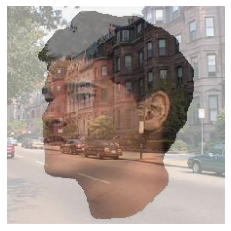

In [8]:
# Merged images load
data_train = [[]  for i in range(12)]
data_train[0] = convertimgs('/content/merge/merge_train/Correct/Male',noise = False)  #75
data_train[1] = convertimgs('/content/merge/merge_train/Correct/Female/',noise = False) #75
data_train[2] = convertimgs('/content/merge/merge_train/Correct/Manmade/',noise = False) #75
data_train[3] = convertimgs('/content/merge/merge_train/Correct/Natural/',noise = False) #75
data_train[4] = convertimgs('/content/merge/merge_train/Correct/Powered',noise = False) #75
data_train[5] = convertimgs('/content/merge/merge_train/Correct/Nonpowered',noise = False) #75

data_train[6] = convertimgs('/content/merge/merge_train/Incorrect/Male',noise = False) #75
data_train[7] = convertimgs('/content/merge/merge_train/Incorrect/Female',noise = False) #75
data_train[8] = convertimgs('/content/merge/merge_train/Incorrect/Manmade',noise = False) #75
data_train[9] = convertimgs('/content/merge/merge_train/Incorrect/Natural',noise = False) #75
data_train[10] = convertimgs('/content/merge/merge_train/Incorrect/Powered',noise = False) #75
data_train[11] = convertimgs('/content/merge/merge_train/Incorrect/Nonpowered',noise = False) #75
data_train = np.array(data_train)
 
data_test = [[]  for i in range(12)]
data_test[0] = convertimgs('/content/merge/merge_test/Correct/Male',noise = False)  #75
data_test[1] = convertimgs('/content/merge/merge_test/Correct/Female/',noise = False) #75
data_test[2] = convertimgs('/content/merge/merge_test/Correct/Manmade/',noise = False) #75
data_test[3] = convertimgs('/content/merge/merge_test/Correct/Natural/',noise = False) #75
data_test[4] = convertimgs('/content/merge/merge_test/Correct/Powered',noise = False) #75
data_test[5] = convertimgs('/content/merge/merge_test/Correct/Nonpowered',noise = False) #75

data_test[6] = convertimgs('/content/merge/merge_test/Incorrect/Male',noise = False) #75
data_test[7] = convertimgs('/content/merge/merge_test/Incorrect/Female',noise = False) #75
data_test[8] = convertimgs('/content/merge/merge_test/Incorrect/Manmade',noise = False) #75
data_test[9] = convertimgs('/content/merge/merge_test/Incorrect/Natural',noise = False) #75
data_test[10] = convertimgs('/content/merge/merge_test/Incorrect/Powered',noise = False) #75
data_test[11] = convertimgs('/content/merge/merge_test/Incorrect/Nonpowered',noise = False) #75
data_test = np.array(data_test)


print(data_train.shape,data_test.shape)

plt.imshow(data_train[0,1])
plt.axis('off')

# Regular Images load

reg_train = [[]  for i in range(12)]
reg_train[0] = convertimgs('/content/merge/merge_reg_train/Correct/Male',noise = False)  # 75
reg_train[1] = convertimgs('/content/merge/merge_reg_train/Correct/Female',noise = False) # 75
reg_train[2] = convertimgs('/content/merge/merge_reg_train/Correct/Manmade',noise = False) # 75
reg_train[3] = convertimgs('/content/merge/merge_reg_train/Correct/Natural/',noise = False) # 75
reg_train[4] = convertimgs('/content/merge/merge_reg_train/Correct/Powered',noise = False) # 75
reg_train[5] = convertimgs('/content/merge/merge_reg_train/Correct/Nonpowered',noise = False) # 75

reg_train[6] = convertimgs('/content/merge/merge_reg_train/Incorrect/Male',noise = False)  # 75
reg_train[7] = convertimgs('/content/merge/merge_reg_train/Incorrect/Female',noise = False) # 75
reg_train[8] = convertimgs('/content/merge/merge_reg_train/Incorrect/Manmade',noise = False) # 75
reg_train[9] = convertimgs('/content/merge/merge_reg_train/Incorrect/Natural/',noise = False) # 75
reg_train[10] = convertimgs('/content/merge/merge_reg_train/Incorrect/Powered',noise = False) # 75
reg_train[11] = convertimgs('/content/merge/merge_reg_train/Incorrect/Nonpowered',noise = False) # 75
reg_train = np.array(reg_train)


reg_test = [[]  for i in range(12)]
reg_test[0] = convertimgs('/content/merge/merge_reg_test/Correct/Male',noise = False)  #75
reg_test[1] = convertimgs('/content/merge/merge_reg_test/Correct/Female/',noise = False) #75
reg_test[2] = convertimgs('/content/merge/merge_reg_test/Correct/Manmade/',noise = False) #75
reg_test[3] = convertimgs('/content/merge/merge_reg_test/Correct/Natural/',noise = False) #75
reg_test[4] = convertimgs('/content/merge/merge_reg_test/Correct/Powered',noise = False) #75
reg_test[5] = convertimgs('/content/merge/merge_reg_test/Correct/Nonpowered',noise = False) #75

reg_test[6] = convertimgs('/content/merge/merge_reg_test/Incorrect/Male',noise = False) #75
reg_test[7] = convertimgs('/content/merge/merge_reg_test/Incorrect/Female',noise = False) #75
reg_test[8] = convertimgs('/content/merge/merge_reg_test/Incorrect/Manmade',noise = False) #75
reg_test[9] = convertimgs('/content/merge/merge_reg_test/Incorrect/Natural',noise = False) #75
reg_test[10] = convertimgs('/content/merge/merge_reg_test/Incorrect/Powered',noise = False) #75
reg_test[11] = convertimgs('/content/merge/merge_reg_test/Incorrect/Nonpowered',noise = False) #75
reg_test = np.array(reg_test)

print(reg_train.shape,reg_test.shape)



### Model Architecture

In [9]:
# Calling VGG16 without the top FC layers with weights loaded from imagenet 
model = VGG16(weights='imagenet',
              include_top=False,input_shape = [224,224,3])
#plot_model(model,show_shapes=True,expand_nested=True)
#model.save_weights('vgg_w',save_format='h5')

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
interest = 0
print('Category of interest: ', categories[interest])
train_it = np.concatenate((reg_train[interest],reg_train[interest + 6]))
test_it = np.concatenate((reg_test[interest],reg_test[interest + 6]))
print(train_it.shape,test_it.shape)

start = time.time()
features_train = model.predict(train_it) 
print(f'Train Time: {time.time() - start}')

start = time.time()
features_test = model.predict(test_it) 
print(f'Test Time: {time.time() - start}')
epochs = 30

ntrain = 80
train_labels = to_categorical([0] * ntrain + [1]*ntrain)


ntest = 40
test_labels = to_categorical([0] * ntest + [1]*ntest) 

losses = 'binary_crossentropy'

# Initialize the top model with FC layers. These are the only ones to be trained
top_model = Sequential()
top_model.add(Flatten(input_shape=features_train.shape[1:])) 
top_model.add(Dense(4096, activation='relu',name = 'top_dense1')) 

top_model.add(Dense(2, activation='softmax',name = 'predictions'))

top_model.compile(optimizer= Adam(lr=1e-5),
              loss=losses,
              metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='loss', mode='min', verbose=1)


58892288/58889256 [==============================] - 1s 0us/step
Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 4.539903163909912
Test Time: 0.6478352546691895
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
blo

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.24373936653137207


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.1722724437713623


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16306257247924805


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.16505742073059082


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.17378568649291992


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.15795350074768066


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


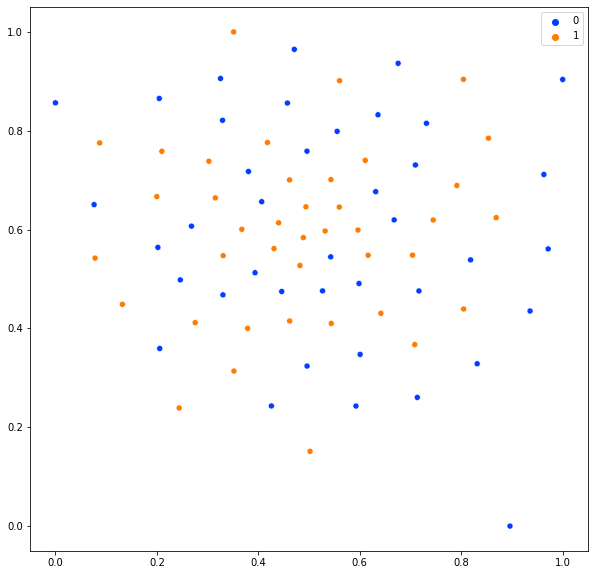

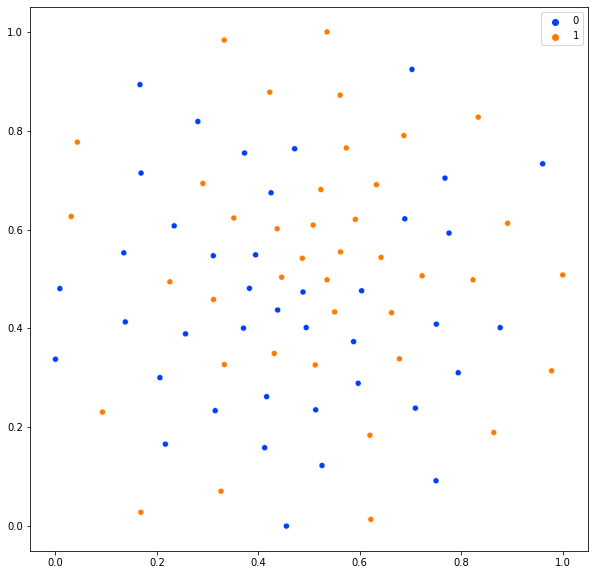

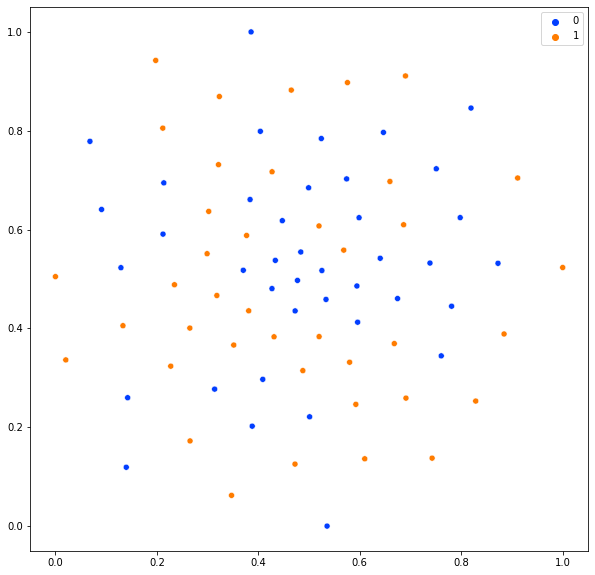

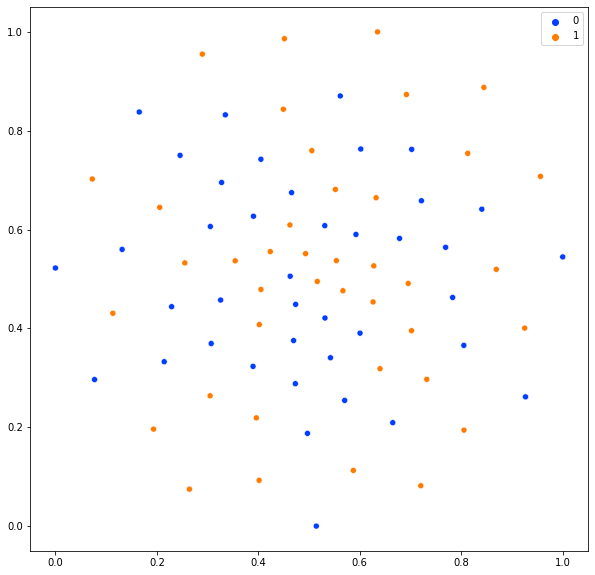

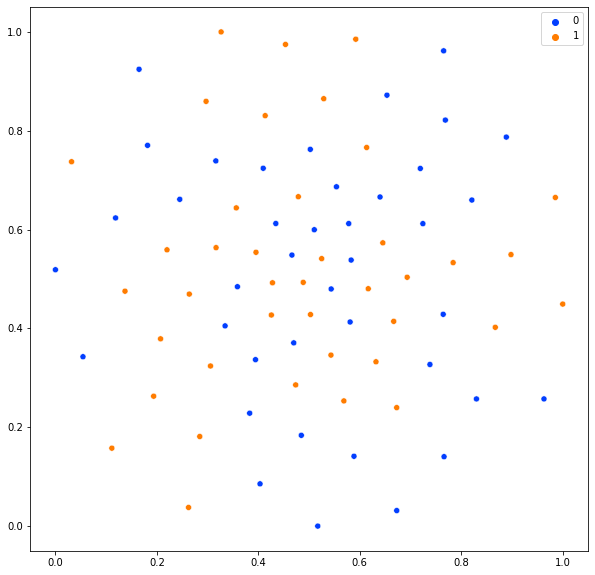

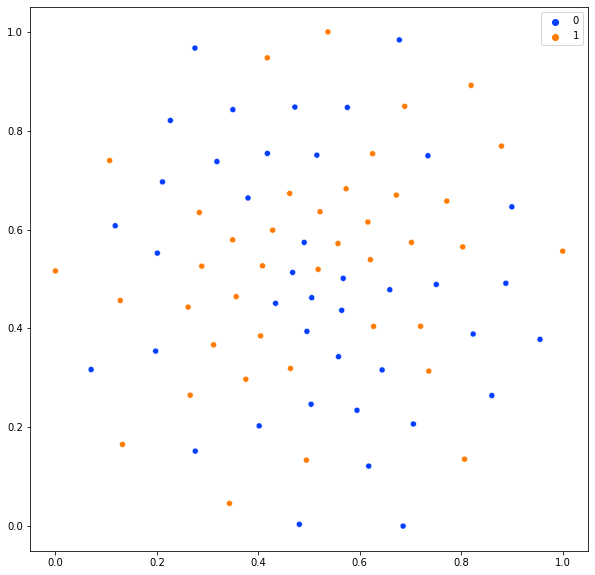

In [44]:

categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']

out = model.get_layer('block5_conv3').output
model_fc7 = Model(model.input,out)
tsne = TSNE()
rndperm = np.random.permutation(80)
df = pd.DataFrame(np.zeros(80))

imtype = 0
for cat in range(6):
  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
  if imtype == 0: # Regular
    test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on regular data
  else:
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
  print(train_it.shape,test_it.shape)

  
  start = time.time()
  features = model_fc7.predict(test_it) 
  print(f'Train Time: {time.time() - start}')


  catunits = np.zeros((len(features),10000))

  for image in range(len(features)):
    x = np.ndarray.flatten(features[image])
    catunits[image,:] = np.random.choice(x,10000)
  if cat == 0:
    units = catunits
  else:
    units = np.vstack((units,catunits))

  reduced = tsne.fit_transform(catunits)
  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))
  plt.figure(figsize = (10,10))
  palette = sns.color_palette("bright", 2)

  sns.scatterplot(reduced_transformed[:,0], reduced_transformed[:,1], hue = [0] * ntest + [1]*ntest,
                   legend='full', palette=palette)

Category of interest:  Male
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.23065924644470215
Test Time: 0.14005398750305176


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Female
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.2385883331298828
Test Time: 0.14829659461975098


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Manmade
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.24489331245422363
Test Time: 0.14994263648986816
Epoch 00009: early stopping


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Natural
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.2393178939819336
Test Time: 0.14424562454223633


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Powered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.23852300643920898
Test Time: 0.1505265235900879


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Category of interest:  Nonpowered
(160, 224, 224, 3) (80, 224, 224, 3)
Train Time: 0.24127793312072754
Test Time: 0.14777278900146484


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


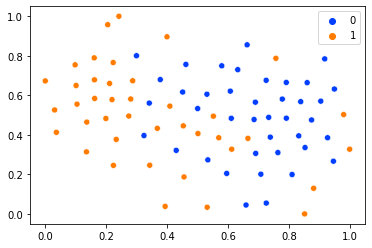

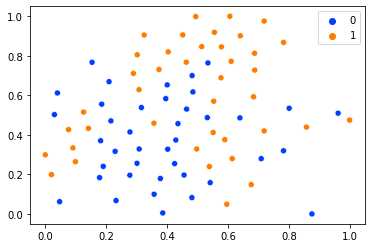

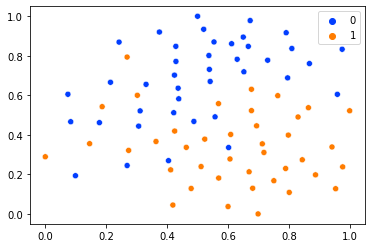

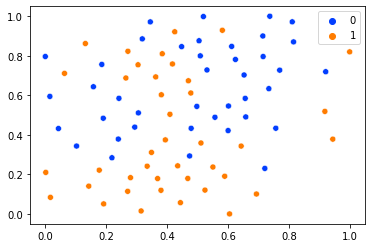

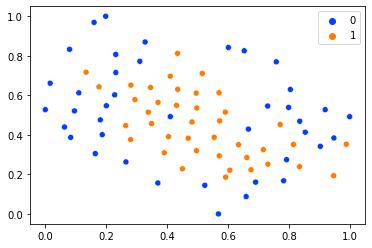

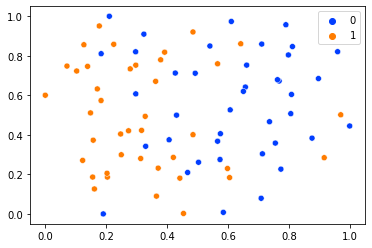

In [45]:
categories = ['Male','Female','Manmade','Natural','Powered','Nonpowered']
out = top_model.get_layer('top_dense1').output
top_model_mod = Model(top_model.input,out)

imtype = 1
for cat in range(6):

  print('Category of interest: ', categories[cat])
  train_it = np.concatenate((reg_train[cat],reg_train[cat + 6])) # Train on regular data
  if imtype == 0: # Regular
    test_it = np.concatenate((reg_test[cat],reg_test[cat + 6])) # Test on regular data
  else:
    test_it = np.concatenate((data_test[cat],data_test[cat + 6])) # Test on merged data
  print(train_it.shape,test_it.shape)

  
  start = time.time()
  train_data = model.predict(train_it) 
  print(f'Train Time: {time.time() - start}')

  start = time.time()
  test_data = model.predict(test_it) 
  print(f'Test Time: {time.time() - start}')
  
  history = top_model.fit(x = train_data,  y = train_labels,
          epochs=epochs,
          batch_size=64,
          verbose = 0, callbacks = [es])

  features = top_model_mod.predict(test_data)
  
  reduced = tsne.fit_transform(features)
  reduced_transformed = reduced - np.min(reduced, axis=0)
  reduced_transformed /= np.max(reduced_transformed, axis=0)
  image_xindex_sorted = np.argsort(np.sum(reduced_transformed, axis=1))

  plt.figure()
  palette = sns.color_palette("bright", 2)

  sns.scatterplot(reduced_transformed[:,0], reduced_transformed[:,1], hue = [0] * ntest + [1]*ntest,
                   legend='full', palette=palette)

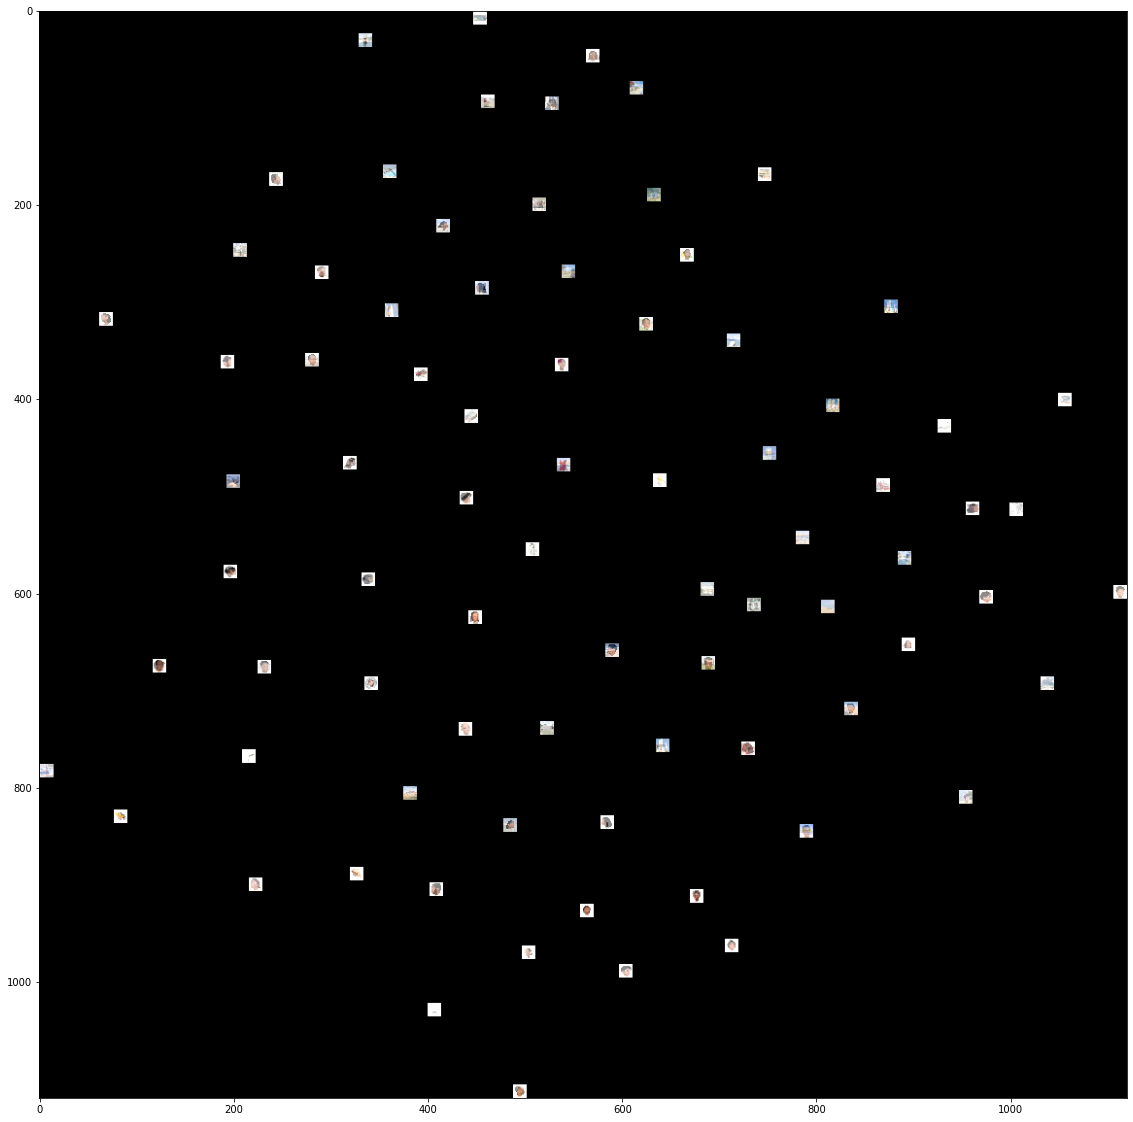

In [37]:
input_size = 224
output_size = 14
bin_size = input_size // output_size
small_image = np.zeros((80,output_size,output_size,3))
for i in range(80):
  small_image[i] = test_it[i].reshape((output_size, bin_size, 
                                     output_size, bin_size, 3)).max(3).max(1)

m_image = np.zeros((output_size*80,output_size*80,3))
for i,idx in enumerate(image_xindex_sorted):
  a = int(np.ceil(reduced_transformed[i, 0] * (output_size*80-output_size-1)+1))
  b = int(np.ceil(reduced_transformed[i, 1] * (output_size*80-output_size-1)+1))
  m_image[a:a+output_size,b:b+output_size,:] = small_image[idx]

plt.figure(figsize = (20,20))
plt.imshow(m_image)

In [34]:
a*output_size

9604